In [11]:
import os,sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pydicom
from pydicom import dcmread
from PIL import Image
import cv2

pathLabels = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"

labels = pd.read_csv(pathLabels)
classInfo = pd.read_csv(classInfoPath)

In [14]:
merged = pd.merge(left = classInfo, right = labels, how = 'left', on = 'patientId') # Merge
merged = merged.drop_duplicates() # Remove duplicates

merged.head()

NameError: ignored

In [ ]:
a = merged.loc[merged['class'] == "No Lung Opacity / Not Normal"]
a['Target'].value_counts()

0    11821
Name: Target, dtype: int64

All patients with No lung capacity are on target 0 and do not have chances of pneumonia

There are no null values

In [ ]:
#Checking for wrong entries like symbols -,?,#,*,etc.
for col in labels.columns:
    print('{} : {}'.format(col,labels[col].unique()))

patientId : ['0004cfab-14fd-4e49-80ba-63a80b6bddd6'
 '00313ee0-9eaa-42f4-b0ab-c148ed3241cd'
 '00322d4d-1c29-4943-afc9-b6754be640eb' ...
 'c1edf42b-5958-47ff-a1e7-4f23d99583ba'
 'c1f6b555-2eb1-4231-98f6-50a963976431'
 'c1f7889a-9ea9-4acb-b64c-b737c929599a']
x : [ nan 264. 562. 323. 695. 288. 547. 306. 650. 181. 571. 703. 652. 301.
 133. 678. 155. 599. 229. 604. 141. 609. 214. 664. 225. 366. 714. 535.
 175. 218. 756. 222. 570. 368. 676. 602. 364. 319. 669. 647. 193. 283.
 642. 247. 617. 698. 326. 744. 136. 655. 633. 317. 185. 231. 616. 730.
 349. 692. 239. 195. 612. 610. 584. 210. 667. 284. 591. 232. 684. 632.
 294. 180. 637. 675. 381. 645. 638. 719. 293. 734. 576. 160. 651. 259.
 613. 228. 256. 614. 110. 518. 138. 563. 219. 529. 179.  82.   6. 459.
 530. 158.  57. 629. 275. 596.  94. 581. 220. 600. 212.  55. 460. 202.
 507. 122. 467. 276. 588. 134. 557. 166. 492.  84. 495. 505. 115. 634.
 266. 129.  87. 510. 152. 512. 153. 503. 496. 102. 504. 217. 592. 548.
 253. 574. 519. 154.  63. 540

In [ ]:
labels.head(1)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0


In [ ]:
merged['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

Almost Evenly distributed classes

In [ ]:
boxNums = merged.dropna()[['x', 'y', 'width', 'height']].copy() # Make a copy of just the boxes

# Calculate x2 & y2 coordinates
boxNums['x2'] = boxNums['x'] + boxNums['width']
boxNums['y2'] = boxNums['y'] + boxNums['height']

# Calculate x2 & y2 centres
boxNums['xCentre'] = boxNums['x'] + boxNums['width']/2
boxNums['yCentre'] = boxNums['y'] + boxNums['height']/2

# Calculate area of the box
boxNums['boxArea'] = boxNums['width'] * boxNums['height']

In [ ]:
df[~df.x.isna()]

In [ ]:
boxNums.head(5)

,x,y,width,height,x2,y2,xCentre,yCentre,boxArea
4,264.0,152.0,213.0,379.0,477.0,531.0,370.5,341.5,80727.0
5,562.0,152.0,256.0,453.0,818.0,605.0,690.0,378.5,115968.0
10,323.0,577.0,160.0,104.0,483.0,681.0,403.0,629.0,16640.0
11,695.0,575.0,162.0,137.0,857.0,712.0,776.0,643.5,22194.0
18,288.0,322.0,94.0,135.0,382.0,457.0,335.0,389.5,12690.0


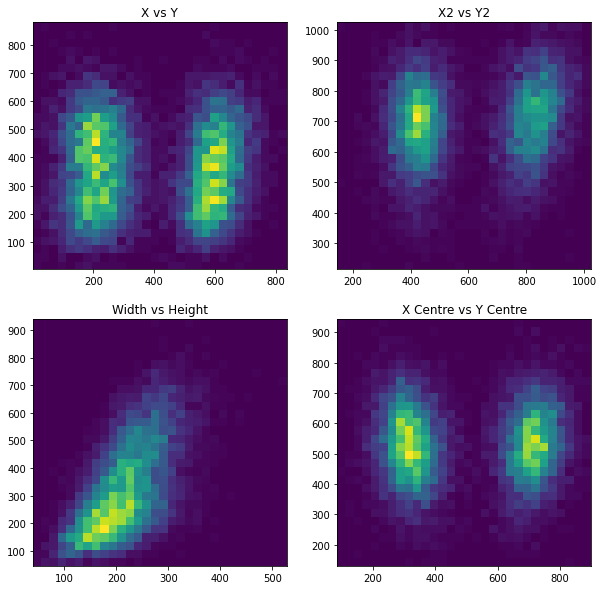

In [ ]:
pairs = [(boxNums['x'], boxNums['y']), (boxNums['x2'], boxNums['y2']), (boxNums['width'], boxNums['height']), 
         (boxNums['xCentre'], boxNums['yCentre'])]

axis = [(0, 0), (0, 1), (1, 0), (1,1)]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for i in range(4):
    axs[axis[i][0], axis[i][1]].hist2d(pairs[i][0], pairs[i][1], bins=30)

# Set titles
axs[0,0].set_title('X vs Y')
axs[0,1].set_title('X2 vs Y2')
axs[1,0].set_title('Width vs Height')
axs[1,1].set_title('X Centre vs Y Centre')

plt.show()   

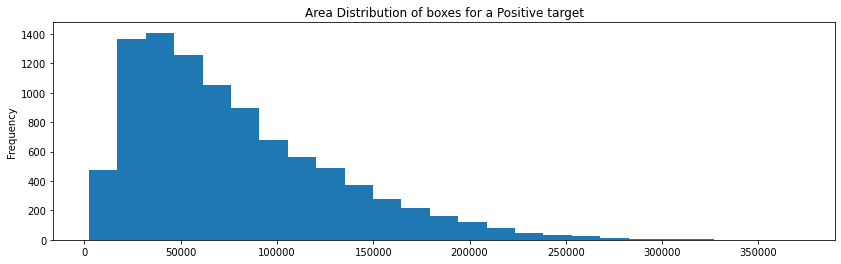

In [ ]:
# Take a look at the distribution of box area
boxNums['boxArea'].plot(kind='hist',
                        bins=25,  
                        figsize=(14,4), 
                        title='Area Distribution of boxes for a Positive target')
plt.show()

In [ ]:
def get_names(path):
    names = []
    for root, dirnames, filenames in os.walk(path):
        for filename in filenames:
            _, ext = os.path.splitext(filename)
            if ext in ['.dcm']:
                names.append(filename)
    
    return names

def convert_dcm_jpg(name):
    
    im = pydicom.dcmread('stage_2_train_images/'+name)

    im = im.pixel_array.astype(float)

    rescaled_image = (np.maximum(im,0)/im.max())*255 # float pixels
    final_image = np.uint8(rescaled_image) # integers pixels

    final_image = Image.fromarray(final_image)

    return final_image

In [ ]:
names = get_names('stage_2_train_images/')
names
for name in names:
    image = convert_dcm_jpg(name)
    image.save('/content/drive/MyDrive/Colab Notebooks/converted_train_images/'+name+'.jpg')

In [15]:
import os
images = os.listdir('/content/drive/MyDrive/Colab Notebooks/converted_train_images')

In [16]:
len(images)

26684

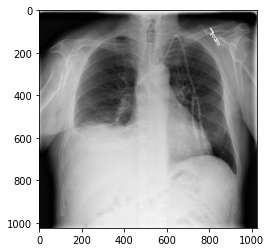

In [19]:
import cv2
import matplotlib.pyplot as plt
base_path = '/content/drive/MyDrive/Colab Notebooks/converted_train_images'
img = cv2.imread(base_path +'/'+images[4])
plt.imshow(img)

In [20]:
img.shape

(1024, 1024, 3)

In [21]:
import numpy as np
mask = np.zeros((1024,1024,))

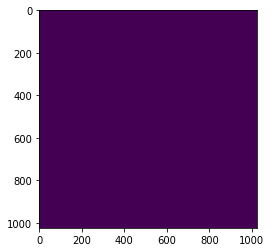

In [22]:
plt.imshow(mask)

In [25]:
x1,y1,w,h=264,152,213,379
mask[x1:x1+w,y1:y1+h]=1

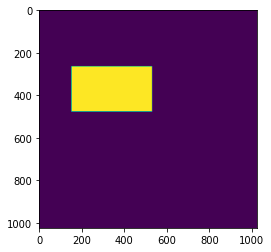

In [26]:
plt.imshow(mask)

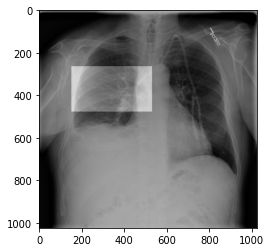

In [27]:
plt.imshow(img,cmap='gray')
plt.imshow(mask,cmap='gray',alpha=0.3)

In [29]:
plt.savefig('my_plot.jpg')

<Figure size 432x288 with 0 Axes>

In [18]:
class_info=pd.read_csv('/content/stage_2_detailed_class_info.csv')
class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
def convert_bbox():
  mask = np.zeros((1024,1024,))
